In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>


In [2]:
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from tqdm import tqdm_notebook as tqdm

from ampy import utils
from ampy import StabilitySelectionVAMPSolver
%matplotlib inline

In [3]:
np.random.seed(0)

# road data

In [4]:
riboflavin_data_A = pd.read_csv("./data/riboflavin/X.csv", header=None)
riboflavin_data_y = pd.read_csv("./data/riboflavin/y.csv", header=None)
A = np.array(riboflavin_data_A, dtype=np.float64)
m, n = A.shape
y = np.array(riboflavin_data_y, dtype=np.float64).reshape(A.shape[0], )
A -= A.mean(axis=0)
A /= A.std(axis=0)
y -= y.mean()
A.shape, y.shape

((71, 4088), (71,))

In [5]:
M, N = A.shape

# cross validation

In [6]:
lasso_cv = linear_model.LassoCV(n_jobs=3, n_alphas=100, cv=10, tol=1e-3, max_iter=1e7, fit_intercept=False)
lasso_cv.fit(A, y)
lasso_cv.alpha_

0.023956316391668977

# VAMP 

## set bootstrap sample size

In [7]:
μ = int(A.shape[0]/2.0)/ A.shape[0]
μ

0.49295774647887325

## do VAMP

In [8]:
# to check the dynamics, we set convergence criterion below the machine epsilon
tol = 1e-100  # convergence criterion 
vamp_solver = StabilitySelectionVAMPSolver(A, y, regularization_strength=lasso_cv.alpha_ * M * np.ones(N), 
                                           mu=μ, clip_min=1e-12, clip_max=1e12, dumping_coefficient=1.0)

_ = vamp_solver.solve(max_iteration=200, tolerance=tol, message=False)  # fit 

doesn't converged
abs_diff= 5.1348804853625076e-17 
abs_diff_v= 1.0367492785564642e-18 
iteration num=199
### x1 ###
self.chi1x_hat 0.189706807276251
self.q1x_hat 3.2721465634685725
self.chi1x 0.0016611756685856027
self.v1x 4.5423475288034924e-05
### u1 ###
self.chi1u_hat 0.12307876629886531
self.q1u_hat 2.689021932833466
self.chi1u 0.11775902432231243
self.v1u 0.009477636659046197
### x2 ###
self.chi2x_hat 42563608620.77131
self.q2x_hat 42566906674.631805
self.chi2x 0.001661175668585603
self.v2x 4.542347528803495e-05
### u2 ###
self.chi2u_hat 0.691548425027312
self.q2u_hat 6.440157069315921
self.chi2u 0.1177590243223124
self.v2u 0.009477636659046194




## time evolution

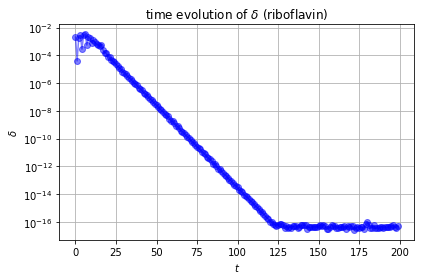

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(vamp_solver.diff_history, "o-", c="b", alpha=0.5)
ax.set_yscale("log")
ax.set_title("time evolution of $\delta$ (riboflavin)")
ax.set_xlabel("$t$")
ax.set_ylabel("$\delta$")
ax.grid()
fig.tight_layout()

## save time evolution

In [10]:
import pickle
with open("time_evolution_riboflavin.pickle", "wb") as f:
    pickle.dump(vamp_solver.diff_history, f, pickle.HIGHEST_PROTOCOL)